# Lab 6: APOGEE Stellar Spectra - Bayesian Linear Regression

**Name:** Taeo Kim

**Date:** Nov 4, 2025

**Keywords:** Bayesian Linear Regression, Error Propagation, Posterior Distribution, Uncertainty Quantification

## Introduction

In this lab, we explore Bayesian linear regression using APOGEE stellar spectra data. We'll learn how to:
- Properly quantify prediction uncertainties
- Understand why naive MLE error estimates fail
- Implement Bayesian linear regression with heteroscedastic noise
- Make predictions with full uncertainty quantification
- Evaluate model calibration using coverage statistics

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting parameters
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Part 1: Loading and Preparing Dataset

### Background
APOGEE (Apache Point Observatory Galactic Evolution Experiment) provides high-resolution infrared spectra of stars. Each spectrum contains flux measurements at different wavelengths that encode information about stellar properties including temperature.

### Task 1a: Load Data and Add Heteroscedastic Noise

Load the dataset and add realistic heteroscedastic noise to temperatures:

$$\sigma_{\text{teff}} = 50 + 150 \cdot \frac{T_{\text{eff}} - T_{\text{min}}}{T_{\text{max}} - T_{\text{min}}}$$

This creates uncertainties ranging from 50K (coolest stars) to 200K (hottest stars).

In [2]:
# TODO: Load 'dataset_apogee_spectra.npz' and extract arrays
file = np.load('dataset_apogee_spectra.npz')
spectra = file['spectrum_array']
wavelength = file['wavelength']
teff_array = file['teff_array']

In [3]:
# TODO: Calculate teff_min, teff_max from teff_array
teff_min = teff_array[np.argmin(teff_array)]
teff_max = teff_array[np.argmax(teff_array)]
# TODO: Calculate sigma_teff using formula: 50 + 150 * (teff - min)/(max - min)
sigma_teff = 50.0 + 150.0*(teff_array - teff_min)/(teff_max - teff_min)
# TODO: Create teff_observed = teff_array + np.random.normal(0, sigma_teff)
teff_observed = teff_array + np.random.normal(0, sigma_teff)

In [4]:
# TODO: Print summary statistics
import pandas as pd
pd.DataFrame(teff_observed).describe()

,0
count,3000.000000
mean,4404.486527
std,714.080084
min,3150.644526
25%,3882.208703
50%,4269.530683
75%,4721.913450
max,7349.615652


### Task 1b: Construct Design Matrix

Create design matrix $\boldsymbol{\Phi}$ with:
- Each row = one star (N stars)
- Each column = one spectral feature (M wavelengths)
- Add bias term (column of ones) at the end

**Question:** What is the final dimension of your design matrix?

In [5]:
spectra.shape

(3000, 2000)

We have 3000 stars (N=3000) and 2000 wavelengths (M=2000)

In [6]:
# TODO:
Phi = np.hstack((spectra, np.ones((len(spectra), 1))))

# TODO: Print Phi.shape - should be (N, M+1)
print(Phi.shape)

(3000, 2001)


Dimension of Phi is indeed (N, M+1)

### Task 1c: Train-Test Split

Split data into 80% training and 20% testing, including uncertainties.

In [7]:
# TODO:
n_train = int(0.8 * len(Phi))
# TODO:
indices = np.random.permutation(len(Phi))
# TODO: Split using indices[:n_train] and indices[n_train:]
idx_train, idx_test = indices[:n_train], indices[n_train:]

In [9]:
# TODO: Create Phi_train, Phi_test, t_train, t_test, sigma_train, sigma_test
Phi_train, Phi_test = Phi[idx_train], Phi[idx_test]
t_train, t_test = teff_observed[idx_train], teff_observed[idx_test]
sigma_train, sigma_test = sigma_teff[idx_train], sigma_teff[idx_test]

### Task 1d: Visualize Spectra

Plot all spectra color-coded by temperature with a colorbar.

In [10]:
# TODO:
colors = plt.cm.plasma((teff_array - teff_min) / (teff_max - teff_min))

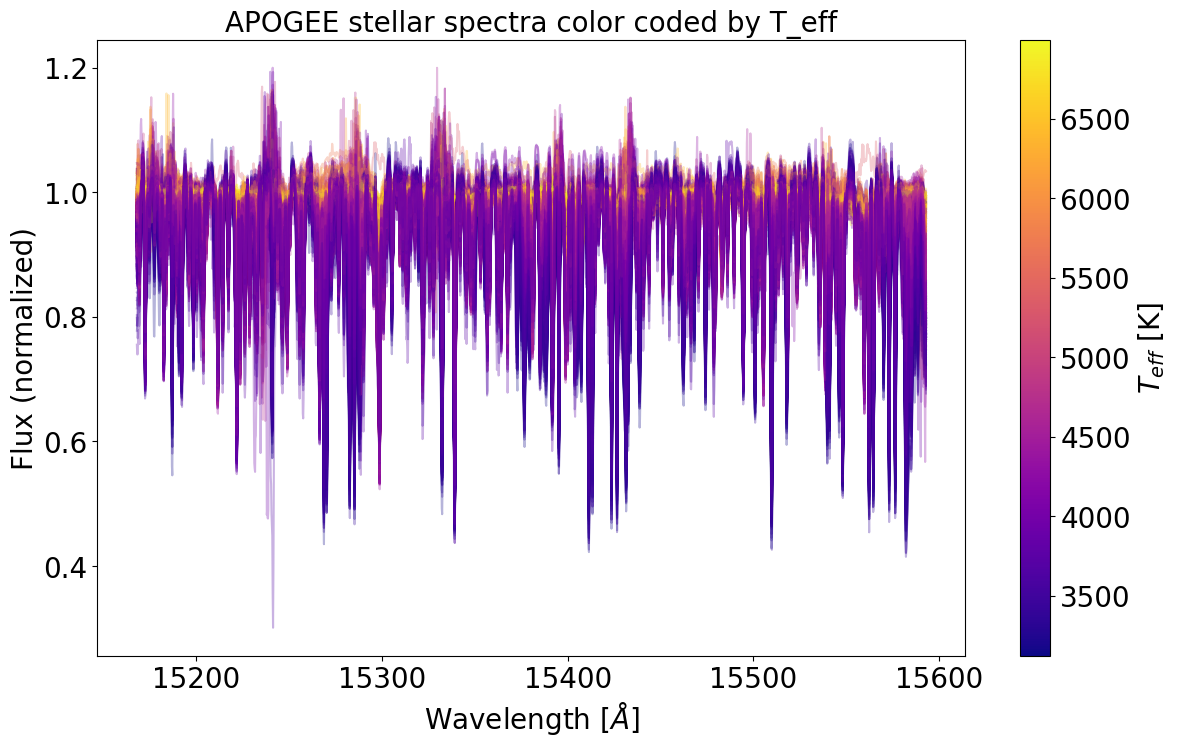

In [16]:
# TODO: Loop: ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)
fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(spectra)):
    ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)
# TODO: Add colorbar with ScalarMappable
norm = plt.Normalize(vmin=teff_min, vmax=teff_max)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label(r"$T_{eff}$ [K]")
# TODO: Set labels and show
ax.set_xlabel(r"Wavelength [$\AA$]")
ax.set_ylabel("Flux (normalized)")
ax.set_title("APOGEE stellar spectra color coded by T_eff")
plt.show()

## Part 2: MLE Error Estimates

### Background
The maximum likelihood solution for linear regression is:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

### Task 2a: Compute MLE and Naive Uncertainty Estimates

Implement the MLE solution and compute RMSE on training and test sets:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

In [22]:
# TODO: Define fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml
    sigma_mle = np.sqrt(np.mean((t_train - pred_train)**2.0))
    rmse_test = np.sqrt(np.mean((t_test - pred_test)**2.0))
    # also return residuals for later
    resi_train = t_train - pred_train
    resi_test = t_test - pred_test
    return sigma_mle, rmse_test, resi_train, resi_test
# TODO: Call function and print ratio rmse_test/sigma_mle
sigma_mle, rmse_test, residuals_train, residuals_test = fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
print(f"Ratio (RMSE_test)/(sigma_mle):\n{rmse_test/sigma_mle}")

Ratio (RMSE_test)/(sigma_mle):
9.44352237428971


### Task 2b: Visualize Residuals

Create two plots:
1. Histogram of training vs test residuals with Gaussian fits

2. Histogram of normalized test residuals compared to N(0,1)

In [27]:
from scipy.stats import norm

AttributeError: 'int' object has no attribute 'items'

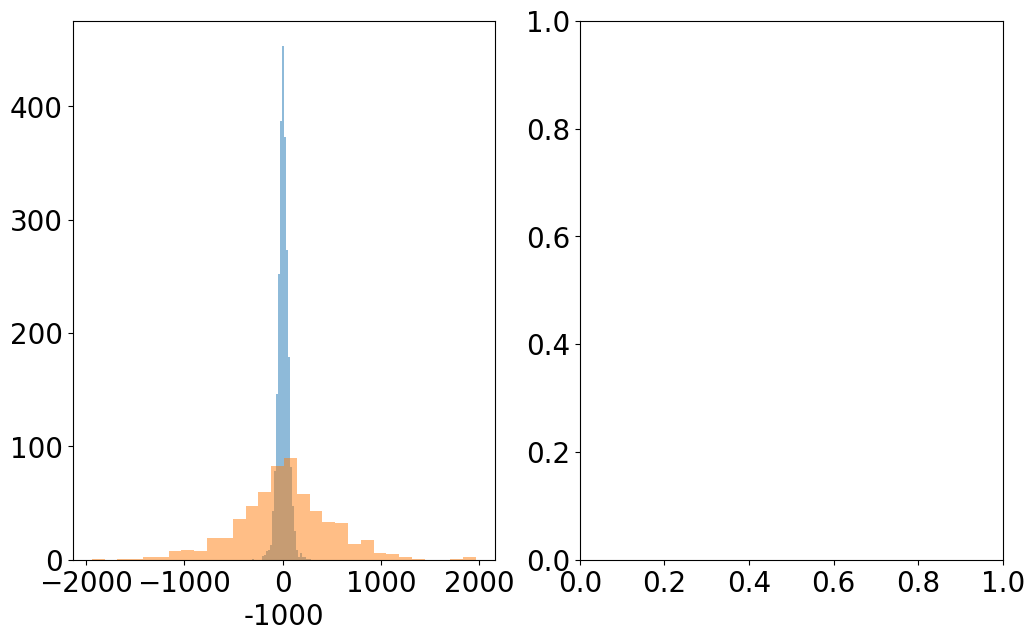

In [28]:
# TODO: Create 2 subplots (1,2)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,7)) 
# TODO: Left: histogram of residuals_train and residuals_test with Gaussian overlays
nBins = 30
# ax1
    # histogram
ax1.hist(residuals_train, bins=nBins, alpha=0.5, label="Training")
ax1.hist(residuals_test, bins=nBins, alpha=0.5,label="Test")
    # Gaussian fit
fit_train, fit_test = norm(0, sigma_mle), norm(0, rmse_test)
ax1.set_xlabel(-1000,1000)
xx = np.linspace(-1000, 1000, 300)
ax1.plot(xx, fit_train.pdf(xx), '--', label="MLE")
ax1.plot(xx, fit_test.pdf(xx), '--', label="Test RMSE")
ax1.legend()
# ax2
# TODO: Right: histogram of (residuals_test / sigma_test) vs N(0,1)
# TODO: Show that normalized residuals have std >> 1.0
plt.show()

**Question:** What do these plots tell us about the naive MLE approach? Why is the normalized residual distribution wider than expected?

## Part 3: Bayesian Linear Regression

### Background
Bayesian linear regression computes a posterior distribution:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$ (posterior covariance)
- $\mathbf{m}_N = \mathbf{S}_N(\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$ (posterior mean)
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ (prior covariance)
- $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$ (measurement covariance)

### Task 3a: Compute Posterior Distribution

Implement the posterior computation for different prior strengths $\eta^2$ = [1000, 100000, 10000000].

In [ ]:
# TODO: Define compute_posterior(Phi, t, sigma, eta2)
# TODO: S0_inv = np.eye(M) / eta2
# TODO: Sigma_inv = np.diag(1 / sigma**2)
# TODO: S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)
# TODO: m_N = S_N @ (Phi.T @ Sigma_inv @ t)
# TODO: Loop eta2_values=[1e3, 1e5, 1e7], compute posteriors

**Questions:** 
- What do $\mathbf{m}_N$ and $\mathbf{S}_N$ represent?
- How does this compare to the naive MLE weights $\mathbf{w}_{\text{ML}}$?

### Task 3b: Visualize Spectral Weights

Plot the spectral weights with uncertainty bands (±2σ) for each prior strength.

In [ ]:
# TODO: Loop posteriors: spectral_weights = m_N[:-1]
# TODO: weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
# TODO: plt.plot(wavelength, spectral_weights)
# TODO: plt.fill_between(wavelength, weights-2*std, weights+2*std, alpha=0.2)

**Question:** Which $\eta^2$ provides the optimal balance? Why?

## Part 4: Making Bayesian Predictions with Uncertainty

### Background
The predictive distribution is:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with:
- Mean: $\mu_* = \mathbf{m}_N^T\boldsymbol{\phi}_*$
- Variance: $\sigma_*^2 = \sigma_{\text{obs},*}^2 + \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_{\text{model}}^2$

### Task 4a: Implement Prediction Function

In [ ]:
# TODO: Define predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model)
# TODO: pred_mean = Phi_new @ m_N
# TODO: param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)
# TODO: pred_var = param_var + sigma_new**2 + sigma_model**2
# TODO: Return pred_mean, np.sqrt(pred_var)

### Task 4b: Visualize Predictions with Uncertainties

Plot predicted vs true temperatures with uncertainty bands.

In [ ]:
# TODO: Loop posteriors, get pred_mean and pred_std
# TODO: plt.scatter(t_test, pred_mean), add y=x line
# TODO: rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
# TODO: z_scores = (t_test - pred_mean) / pred_std
# TODO: coverage = np.mean(np.abs(z_scores) < 2)

### Task 4c: Calculate Coverage

Compute the 95% coverage using Z-scores:

$$z = \frac{t_{\text{true}} - t_{\text{predicted}}}{\sigma_{\text{predicted}}}$$

For well-calibrated uncertainties, ~95% of z-scores should have |z| < 2.

In [ ]:
# TODO: Loop posteriors
# TODO: Get predictions, calculate z_scores and coverage
# TODO: Print f"η²={eta2:.0e}: RMSE={rmse:.1f}K, Coverage={coverage:.3f}"

**Questions:**
- Which prior gives the best coverage?
- What does coverage < 0.95 indicate?
- What does coverage > 0.95 indicate?

## Bonus: Visualize Z-score Distribution

### Task 4d: Plot Z-scores

Compare the z-score distribution to the expected N(0,1).

In [ ]:
# TODO: m_N_opt, S_N_opt = posteriors[1]  # eta2=1e5
# TODO: Get predictions and z_scores = (t_test - pred_mean) / pred_std
# TODO: plt.hist(z_scores), overlay (1/sqrt(2π)) * exp(-x²/2)
# TODO: Print mean and std of z_scores (should be ~0 and ~1)

**Question:** Are your uncertainties well-calibrated? How can you tell?

## Summary and Conclusions

**Key Takeaways:**

1. **Naive MLE fails:** Training RMSE severely underestimates prediction uncertainty due to overfitting

2. **Bayesian approach:** Properly accounts for parameter uncertainty, measurement noise, and model inadequacy

3. **Prior selection:** The prior strength $\eta^2$ controls the balance between flexibility and regularization

4. **Calibration matters:** Well-calibrated uncertainties are essential for scientific inference

5. **Uncertainty decomposition:** Understanding different sources of error helps guide improvement efforts

**Your findings:**

[Write your conclusions here - which prior was optimal? What was the final RMSE and coverage?]